In [2]:
from typing import List, Tuple
from enum import Enum
import seaborn as sns
import os
import pandas as pd
import json
import numpy as np
from statistics import mean, stdev
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib import collections
from matplotlib.patches import PathPatch
import matplotlib.path as mpath

In [4]:
class DetectionAlgorithmsNames(Enum):
    """
    Enum class for the detection algorithms
    """
    LOUV = "louvain"
    WALK = "walktrap"
    GRE = "greedy"

class FilePaths(Enum):
    """Class to store file paths for data and models"""

    # ° Local
    DATASETS_DIR = "dataset/data"
    LOG_DIR = "src/logs/"
    TEST_DIR = "test/"

    # USED DATASETS
    KAR = DATASETS_DIR + "/kar.mtx"
    WORDS = DATASETS_DIR + "/words.mtx"
    VOTE = DATASETS_DIR + "/vote.mtx"
    FB_75 = DATASETS_DIR + "/fb-75.gml"
    POW = DATASETS_DIR + "/pow.gml"

In [5]:
def check_dir(path: str):
        """
        Check if the directory exists, if not create it.

        Parameters
        ----------
        path : str
            Path to the directory
        """
        if not os.path.exists(path):
            os.makedirs(path)

# F1 SCORE

In [44]:
def plot_f1_all_datasets(
            datasets: List[str], 
            detection_algs: List[str],
            taus: List[float],
            betas: List[float]
            ):
        """
        Plot the f1 scores of the evaluation on all the datasets and detection algorithms

        Parameters
        ----------
        datasets : List[str]
            List of datasets
        detection_algs : List[str]
            List of detection algorithms
        taus : List[float]
            List of tau values
        betas : List[float]
            List of beta values
        """

        datasets_names = {
            FilePaths.KAR.value: "kar",
            FilePaths.WORDS.value: "words",
            FilePaths.VOTE.value: "vote",
            FilePaths.POW.value: "pow",
            FilePaths.FB_75.value: "fb",
        }

        save_path = "../test_review/all_datasets/f1_score/"
        check_dir(save_path)
        log_name = "evaluation_node_hiding"

        agent_renamed = "DRL-Agent"
        centrality_renamed = "Betweenness"
        dcmh_renamed = r"$\nabla\text{-CMH (ours)}$"

        evading_algs=["DCMH","Agent","Random","Greedy","Degree","Roam","Centrality"]
        metric = "F1 score"

        datasets = [datasets_names[dataset] for dataset in datasets]

        f1_dict = {}
        for dataset in datasets:
            f1_dict[dataset] = {}
            for detection_alg in detection_algs:
                f1_dict[dataset][detection_alg] = {}
                for tau in taus:
                    f1_dict[dataset][detection_alg][f"tau_{tau}"] = {}
                    for beta in betas:
                        f1_dict[dataset][detection_alg][f"tau_{tau}"][f"beta_{beta}"] = {}
                        json_path = f"../test_review/{dataset}/{detection_alg}/node_hiding/tau_{tau}/beta_{beta}/{log_name}.json"
                        with open(json_path, "r") as f:
                            log = json.load(f)
                        for alg in evading_algs:
                            f1_dict[dataset][detection_alg][f"tau_{tau}"][f"beta_{beta}"][alg] = [
                                (2 * x * y) / (x + y)
                                for x, y in zip(log[alg]["goal"], log[alg]["nmi"])
                            ]


        for detection_alg in detection_algs:
            for tau in taus:
                for beta in betas:
                    plot_data = []
                    for dataset in datasets:
                        df = pd.DataFrame(f1_dict[dataset][detection_alg][f"tau_{tau}"][f"beta_{beta}"])
                        plot_data.append(df)
                    df = pd.concat(plot_data,axis=1)
                    # in algs list replace "Agent" with "DRL-Agent"
                    evading_algs = [agent_renamed if alg == "Agent" else alg for alg in evading_algs]
                    # in algs list replace "Centrality" with "Betweenness"
                    evading_algs = [centrality_renamed if alg == "Centrality" else alg for alg in evading_algs]
                    # in algs list replace "DCMH" with "Grad-CMH (ours)"
                    evading_algs = [dcmh_renamed if alg == "DCMH" else alg for alg in evading_algs]
                    # in datasets list replace "fb" with "fb-75"
                    datasets_renamed = ["fb-75" if dataset == "fb" else dataset for dataset in datasets]
                    df.columns = pd.MultiIndex.from_product([datasets_renamed, evading_algs])
                    # Melt the dataframe
                    df = df.melt(var_name=["Dataset", "Algorithm"], value_name=metric)
                    max_value = df.groupby(['Dataset', 'Algorithm'])[metric].mean().max()


                    # Definizione del tuo metodo e delle baseline
                    my_model = r"$\nabla\text{-CMH (ours)}$"  # Sostituisci con il nome del tuo metodo
                    baseline_models = ["DRL-Agent", "Random", "Greedy","Degree",  "Roam","Betweenness"  ]  

                    
                    # Palette personalizzata 1
                    custom_palette = {
                        my_model: "#033dff",  
                        baseline_models[0]: "#4b4d52",  
                        baseline_models[1]: "#3d6cf5",       
                        baseline_models[2]: "#858ca1",     
                        baseline_models[3]: "#829eed",        
                        baseline_models[4]: "#c0c1c2",    
                        baseline_models[5]: "#c0ccf0"   
                    }
                    """
                    # Palette personalizzata alternativa
                    custom_palette = {
                        my_model: "#0047AB",  
                        baseline_models[0]: "#696969",  
                        baseline_models[1]: "#4682B4",       
                        baseline_models[2]: "#A9A9A9",     
                        baseline_models[3]: "#ADD8E6",        
                        baseline_models[4]: "#D3D3D3",    
                        baseline_models[5]: "#CCCCFF"   
                    }
                    """
                    sns.set_theme(style="whitegrid")
                    #plt.rcParams['text.usetex'] = False  
                    g = sns.catplot(
                        data=df,
                        kind="bar",
                        x="Dataset",
                        y=metric,
                        hue="Algorithm",
                        aspect=2,
                        palette=custom_palette,
                        errorbar=('ci',90),
                        legend=False,
                        capsize=0.3,
                        err_kws={
                            'linewidth': .7,   # Spessore della barra di errore
                            'color': 'black',    # Colore nero per le barre
                        },
                    )
                    g.set_axis_labels("Datasets", f"{metric.capitalize()}", fontsize=25)
                    g.set_yticklabels(fontsize=20)
                    g.set_xticklabels(ha="center", fontsize=25)
                    if max_value > 0.9:
                        g.set(ylim=(0, 1))
                    # Ottieni i colori dalla palette personalizzata
                    custom_handles = [
                        Patch(facecolor=custom_palette[alg], label=alg, hatch='//' if alg == my_model else '')
                        for alg in df['Algorithm'].unique()
                    ]

                    # Posiziona la legenda
                    #sns.move_legend(g, "upper center", bbox_to_anchor=(0.43, 1.1), frameon=False, ncol=7)
                    plt.legend(handles=custom_handles, loc='upper center', bbox_to_anchor=(0.47, 1.3), frameon=False, ncol=4, fontsize=20)
                    for ax in g.axes.flat:
                        ax.spines["top"].set_visible(True)
                        ax.spines["right"].set_visible(True)
                        #ax.spines["top"].set_linewidth(2)
                        #ax.spines["right"].set_linewidth(2)
                        #ax.spines["left"].set_linewidth(2)
                        #ax.spines["bottom"].set_linewidth(2)
                        ax.spines["top"].set_color("black")
                        ax.spines["right"].set_color("black")
                        ax.spines["left"].set_color("black")
                        ax.spines["bottom"].set_color("black")
                    indices_to_hatch_lines = [0,1,2,3,4]  # Indici delle barre a cui applicare il tratteggio
                    indices_to_hatch_cross = [5,6,7,8,9]  # Indici delle barre a cui applicare la croce
                    for ax in g.axes.flat:  # Per ogni asse nel grafico
                        bars = ax.patches  # Ottieni tutte le barre
                        bars = [bar for bar in ax.patches if bar.get_height() > 0]
                        for i, bar in enumerate(bars):  # Itera sulle barre
                            if i in indices_to_hatch_lines:  # Se l'indice è nella lista
                                bar.set_hatch('//')  # Applica il tratteggio
                            #if i in indices_to_hatch_cross:
                                #bar.set_hatch('\\')  # Applica la croce

                    save_fig_path = f"{save_path}/{detection_alg}/tau_{tau}/beta_{beta}"
                    check_dir(save_fig_path)
                    g.savefig(
                        f"{save_fig_path}/f1_score_grouped.png",
                        bbox_inches="tight",
                        dpi=300,
                    )

# COMPUTATIONAL TIME

In [54]:
def plot_time_all_datasets(
            datasets: List[str], 
            detection_algs: List[str],
            taus: List[float],
            betas: List[float]
            ):
        """
        Plot the time of the evaluation on all the datasets and detection algorithms

        Parameters
        ----------
        datasets : List[str]
            List of datasets
        detection_algs : List[str]
            List of detection algorithms
        taus : List[float]
            List of tau values
        betas : List[float]
            List of beta values
        """

        datasets_names = {
            FilePaths.KAR.value: "kar",
            FilePaths.WORDS.value: "words",
            FilePaths.VOTE.value: "vote",
            FilePaths.POW.value: "pow",
            FilePaths.FB_75.value: "fb",
        }

        dataset_sizes = {
            "kar": 34*78,
            "words": 112*425,
            "vote": 889*2900,
            "pow": 4941*6954,
            "fb": 6386*217662,
        }

        save_path = "../test_review/all_datasets/time/"
        check_dir(save_path)
        log_name = "evaluation_node_hiding"


        evading_algs=["Agent","DCMH"]
        metric = "Time"

        datasets = [datasets_names[dataset] for dataset in datasets]

        time_dict = {}
        for dataset in datasets:
            time_dict[dataset] = {}
            for detection_alg in detection_algs:
                time_dict[dataset][detection_alg] = {}
                for tau in taus:
                    time_dict[dataset][detection_alg][f"tau_{tau}"] = {}
                    for beta in betas:
                        time_dict[dataset][detection_alg][f"tau_{tau}"][f"beta_{beta}"] = {}
                        json_path = f"../test_review/{dataset}/{detection_alg}/node_hiding/tau_{tau}/beta_{beta}/{log_name}.json"
                        with open(json_path, "r") as f:
                            log = json.load(f)
                        for alg in evading_algs:
                            time_dict[dataset][detection_alg][f"tau_{tau}"][f"beta_{beta}"][alg] = {
                                "mean": mean(log[alg]["time"]),
                                "std": stdev(log[alg]["time"]),
                            }

        x_values = [dataset_sizes[dataset] for dataset in datasets]
        
        dcmh_color = "#033dff"
        agent_color = "#4b4d52"

        for detection_alg in detection_algs:
            for tau in taus:
                for beta in betas:
                    plot_data=[]
                    for dataset in datasets:
                        dict = time_dict[dataset][detection_alg][f"tau_{tau}"][f"beta_{beta}"]
                        plot_data.append(dict)
                    time_agent_mean = np.array([dict["Agent"]["mean"] for dict in plot_data])
                    #time_agent_std = np.array([dict["Agent"]["std"] for dict in plot_data])
                    time_dcmh_mean = np.array([dict["DCMH"]["mean"] for dict in plot_data])
                    #time_dcmh_std = np.array([dict["DCMH"]["std"] for dict in plot_data])

                    sns.set_theme(style="whitegrid")
                    plt.figure(figsize=(16, 8))
                    plt.scatter(x_values, time_dcmh_mean,label=r'$\nabla$-CMH (ours)', s=300, marker='o', color=dcmh_color, hatch='/') 
                    plt.scatter(x_values, time_agent_mean,label='DRL-Agent', s=300, marker='D', color=agent_color)
                    plt.plot(x_values, time_dcmh_mean, 'r--', color=dcmh_color, linewidth=2, alpha=0.5)
                    plt.plot(x_values, time_agent_mean, 'r--', color=agent_color, linewidth=2, alpha=0.5)
                    plt.loglog()
                    plt.ylim(0.0001,1000)
                    plt.xlabel(r'Network size ($|V| \cdot |E|$)', fontsize=33)                    
                    plt.ylabel('Evasion Time (s)',fontsize=33)
                    custom_labels = [f"kar\n(2.6k)", "words\n(476k)", "vote\n(2.57M)", "pow\n(34.3M)", "fb-75\n(1.38B)"]
                    plt.xticks(ticks=x_values, labels=custom_labels,ha="center", fontsize=28)
                    plt.yticks(fontsize=25)
                    plt.legend(fontsize=30)
                    plt.grid(True)
                    ax = plt.gca()
                    ax.spines["top"].set_visible(True)
                    ax.spines["right"].set_visible(True)
                    ax.spines["top"].set_linewidth(1.8)
                    ax.spines["right"].set_linewidth(1.8)
                    ax.spines["left"].set_linewidth(1.8)
                    ax.spines["bottom"].set_linewidth(1.8)
                    ax.spines["top"].set_color("black")
                    ax.spines["right"].set_color("black")
                    ax.spines["left"].set_color("black")
                    ax.spines["bottom"].set_color("black")

                    save_fig_path = f'{save_path}/{detection_alg}/tau_{tau}/beta_{beta}'
                    check_dir(save_fig_path)
                    plt.savefig(f'{save_fig_path}/evading_time_grouped.png', format='png', dpi=300, bbox_inches="tight") 

# FUNCTION CALLS

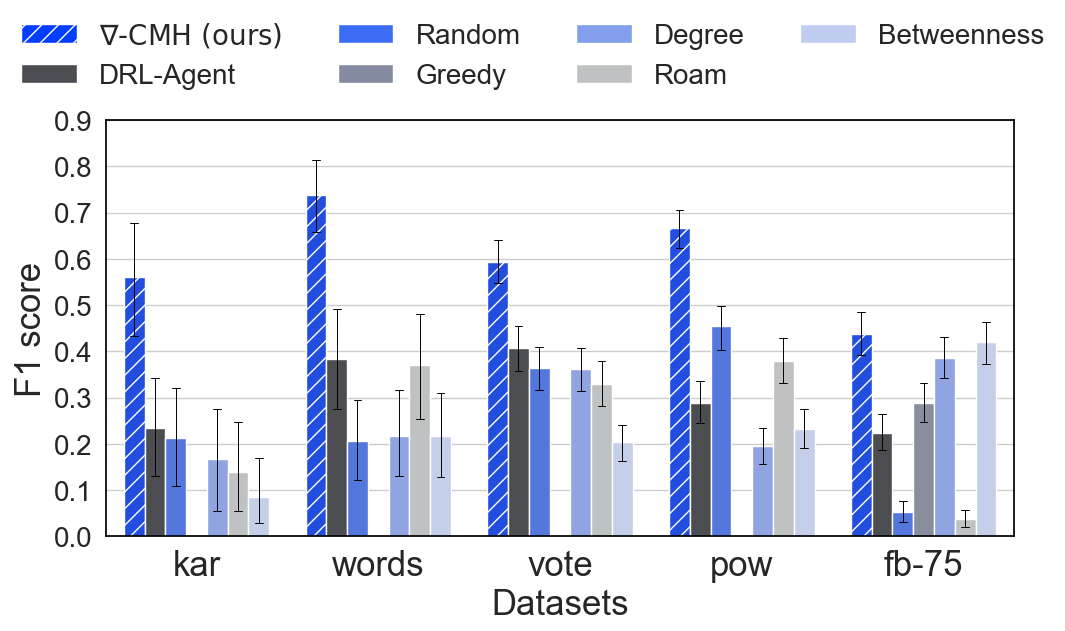

In [45]:
plot_f1_all_datasets(
            datasets= [FilePaths.KAR.value, FilePaths.WORDS.value, FilePaths.VOTE.value, FilePaths.POW.value, FilePaths.FB_75.value],
            detection_algs= [DetectionAlgorithmsNames.GRE.value],
            taus=[0.5],
            betas=[0.5],
        )

/var/folders/gb/156njh5s6ylf2hkl4_yqxsw80000gn/T/ipykernel_1523/2146425118.py:87: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_values, time_dcmh_mean, 'r--', color=dcmh_color, linewidth=2, alpha=0.5)
/var/folders/gb/156njh5s6ylf2hkl4_yqxsw80000gn/T/ipykernel_1523/2146425118.py:88: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_values, time_agent_mean, 'r--', color=agent_color, linewidth=2, alpha=0.5)


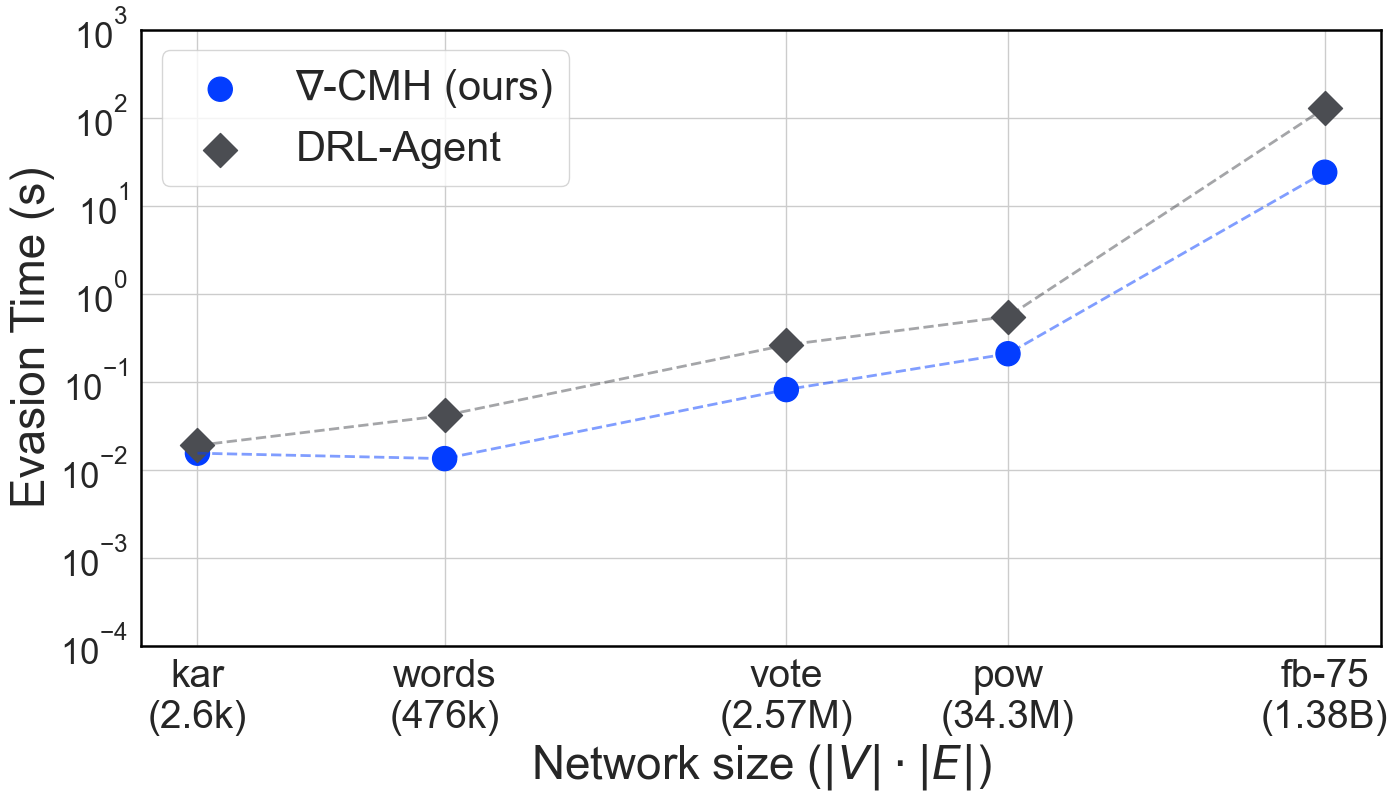

In [55]:
plot_time_all_datasets(
            datasets= [FilePaths.KAR.value, FilePaths.WORDS.value, FilePaths.VOTE.value, FilePaths.POW.value, FilePaths.FB_75.value],
            detection_algs= [ DetectionAlgorithmsNames.GRE.value],
            taus=[0.5],
            betas=[1],
        )

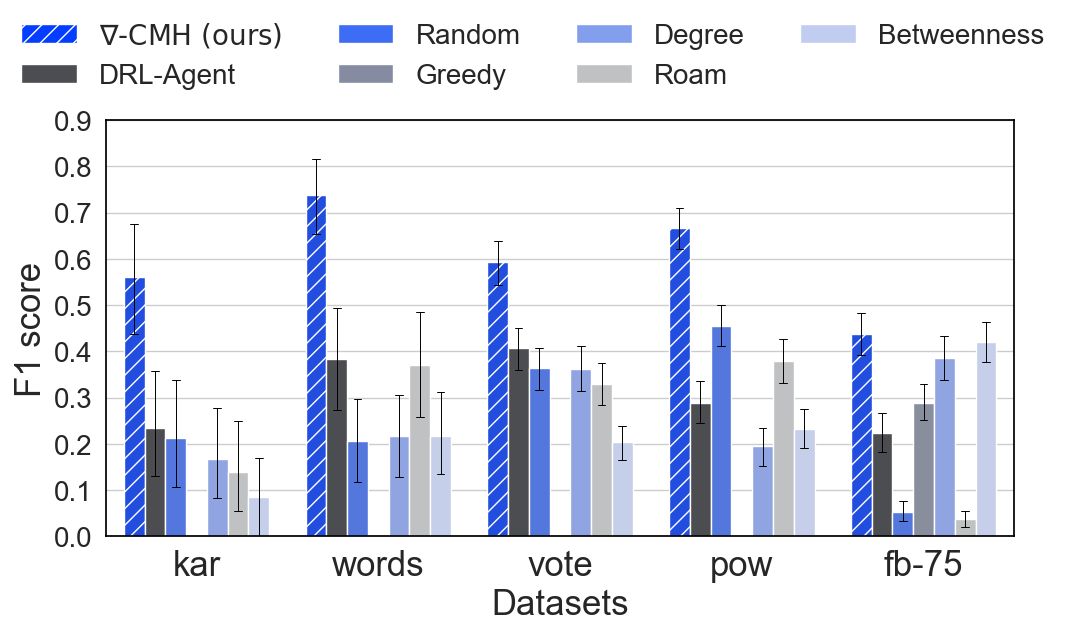

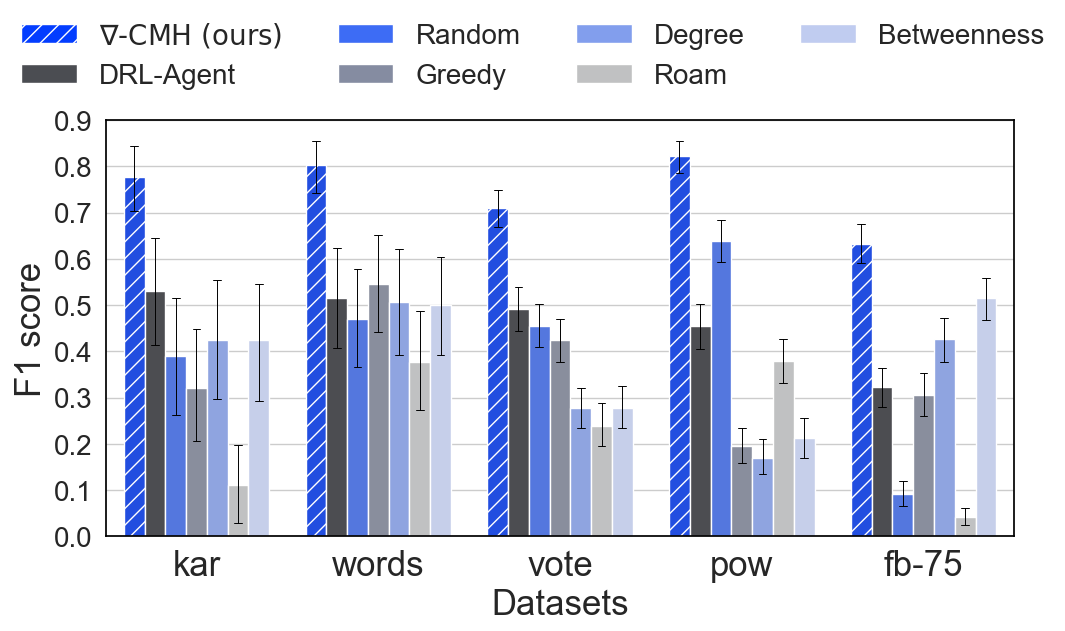

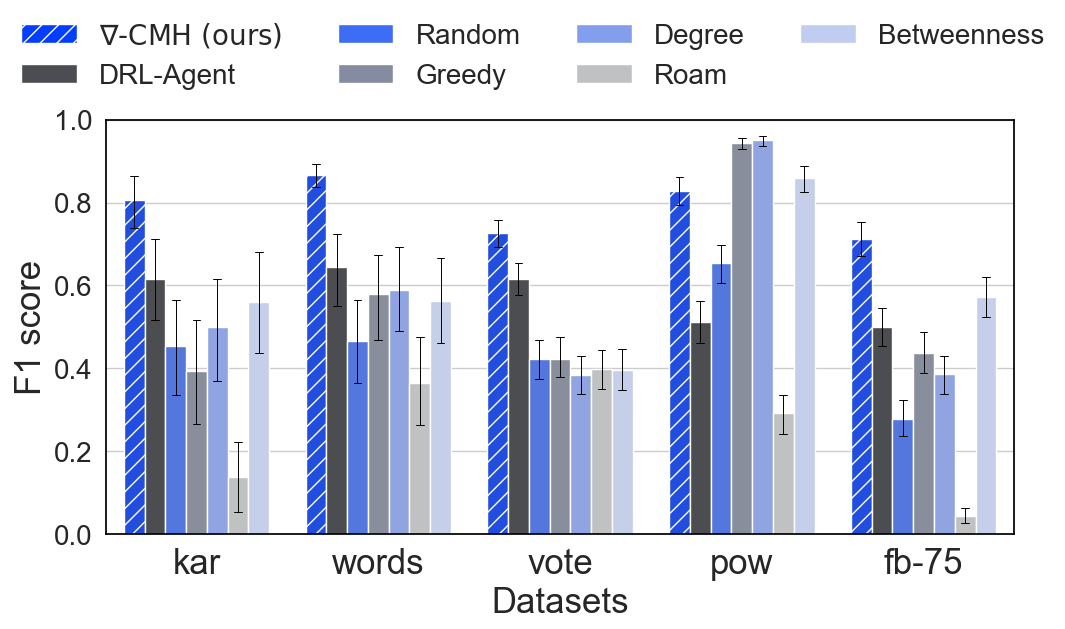

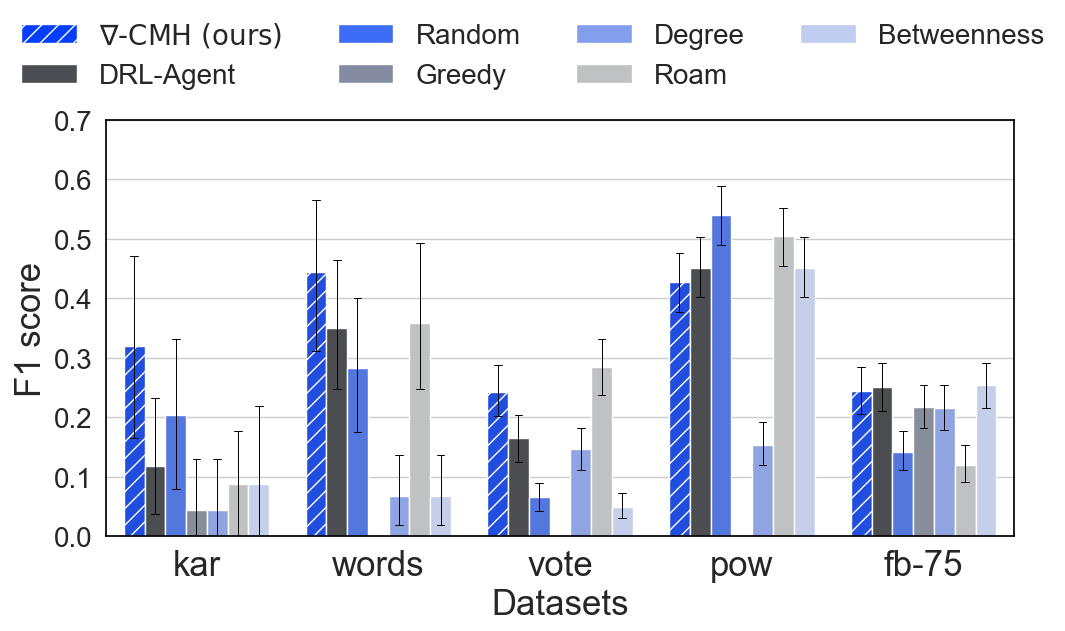

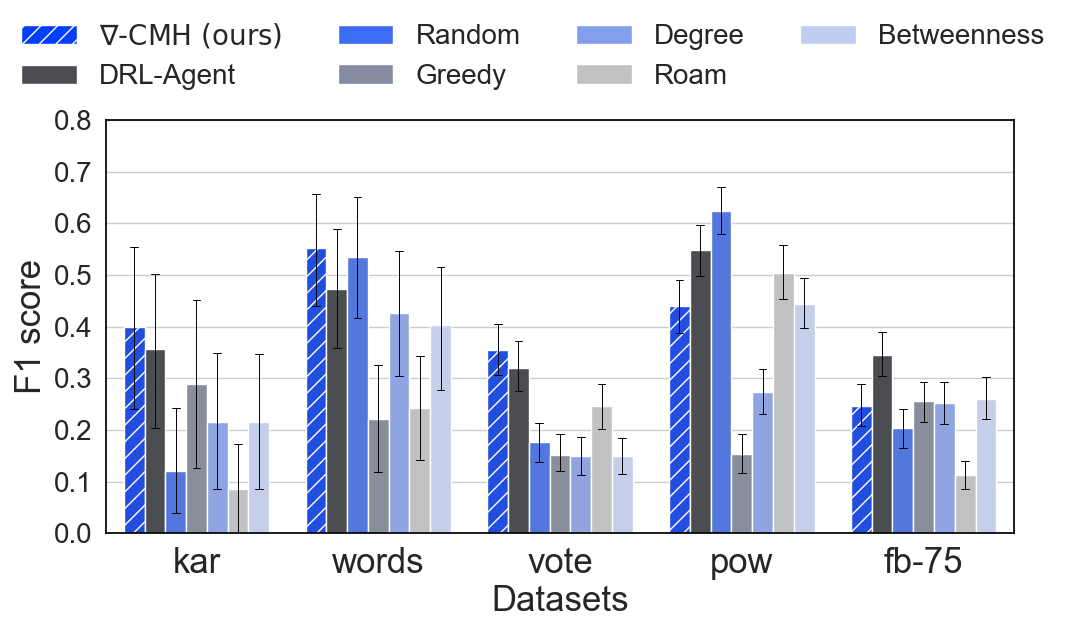

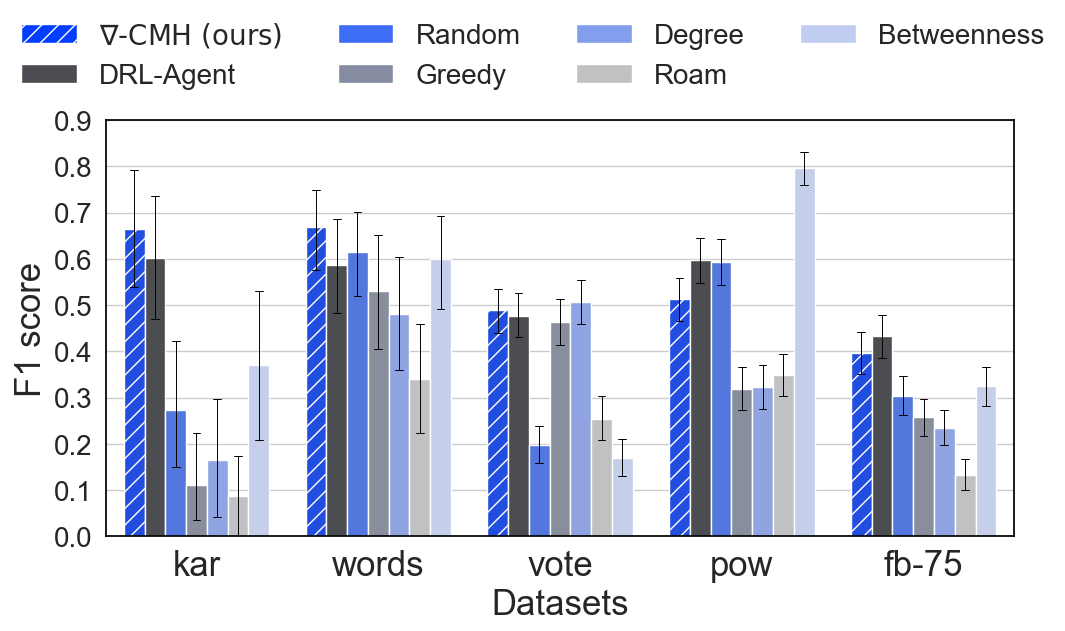

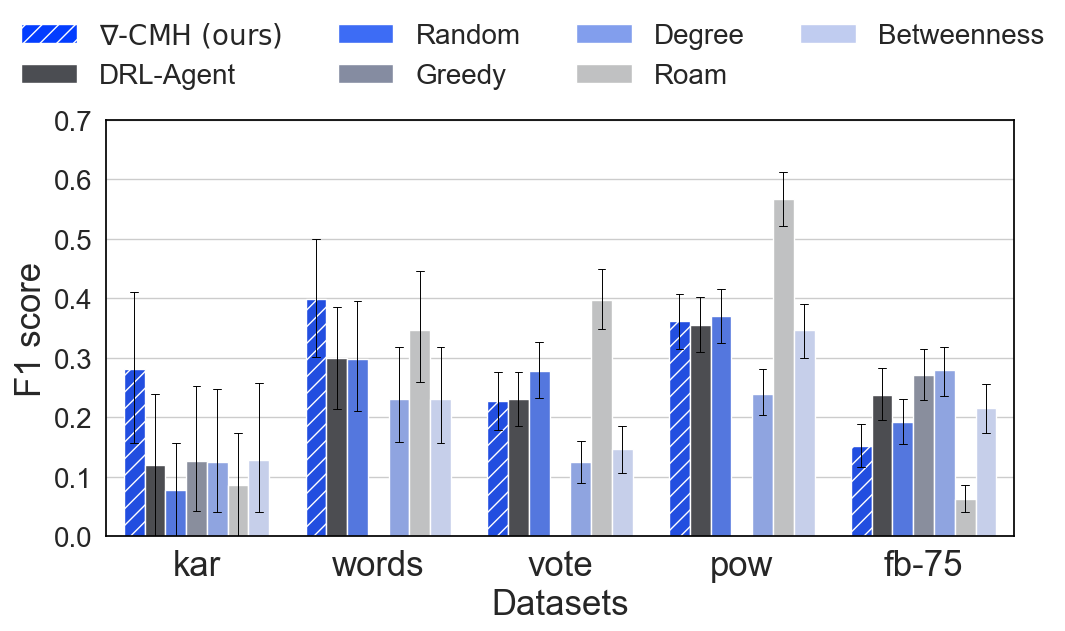

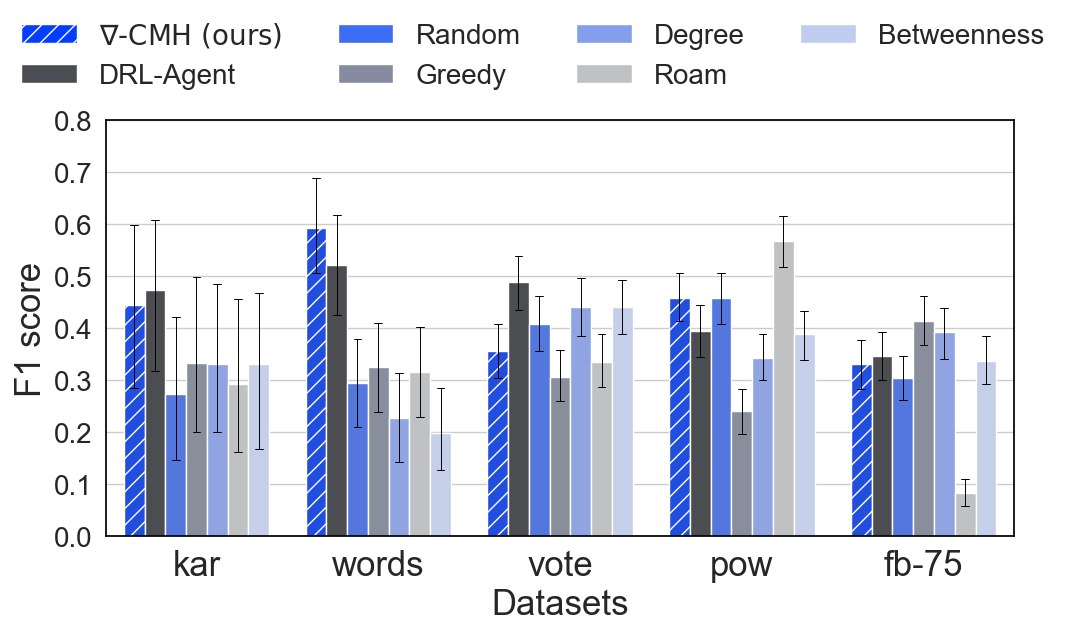

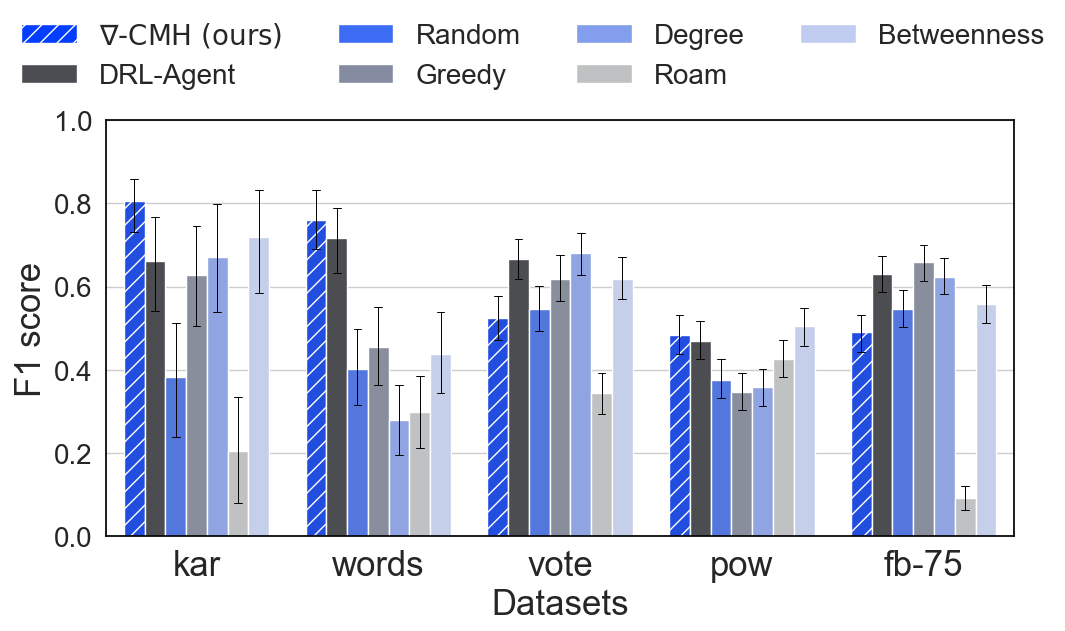

In [38]:
plot_f1_all_datasets(
            datasets= [FilePaths.KAR.value,FilePaths.WORDS.value, FilePaths.VOTE.value, FilePaths.POW.value, FilePaths.FB_75.value],
            detection_algs= [ DetectionAlgorithmsNames.GRE.value, DetectionAlgorithmsNames.LOUV.value,DetectionAlgorithmsNames.WALK.value],
            taus=[0.5],
            betas=[0.5,1,2],
        )

/var/folders/gb/156njh5s6ylf2hkl4_yqxsw80000gn/T/ipykernel_1523/2146425118.py:87: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_values, time_dcmh_mean, 'r--', color=dcmh_color, linewidth=2, alpha=0.5)
/var/folders/gb/156njh5s6ylf2hkl4_yqxsw80000gn/T/ipykernel_1523/2146425118.py:88: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_values, time_agent_mean, 'r--', color=agent_color, linewidth=2, alpha=0.5)
/var/folders/gb/156njh5s6ylf2hkl4_yqxsw80000gn/T/ipykernel_1523/2146425118.py:87: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_values, time_dcmh_mean, 'r--', color=dcmh_color, linewidth=2, alpha=0.5)
/var/folders/gb/156n

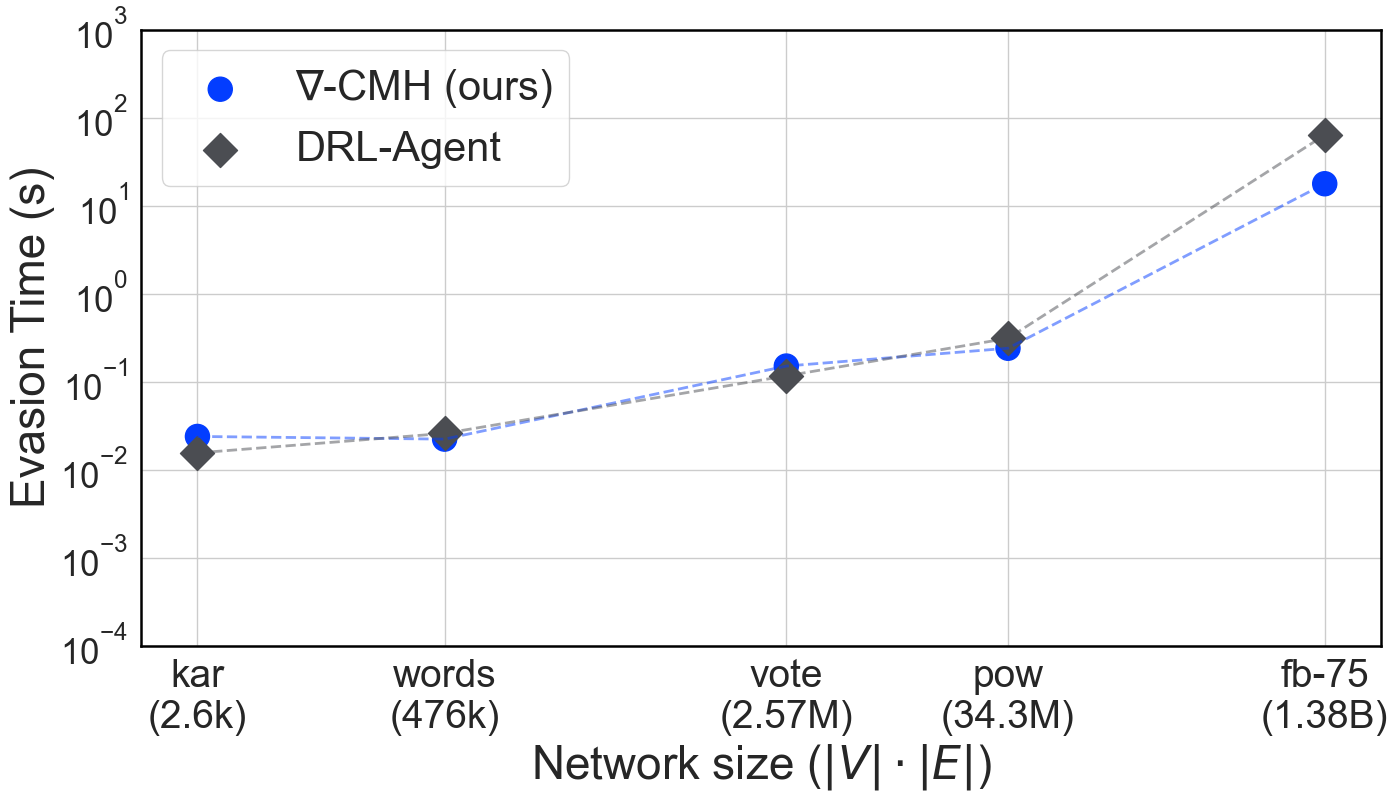

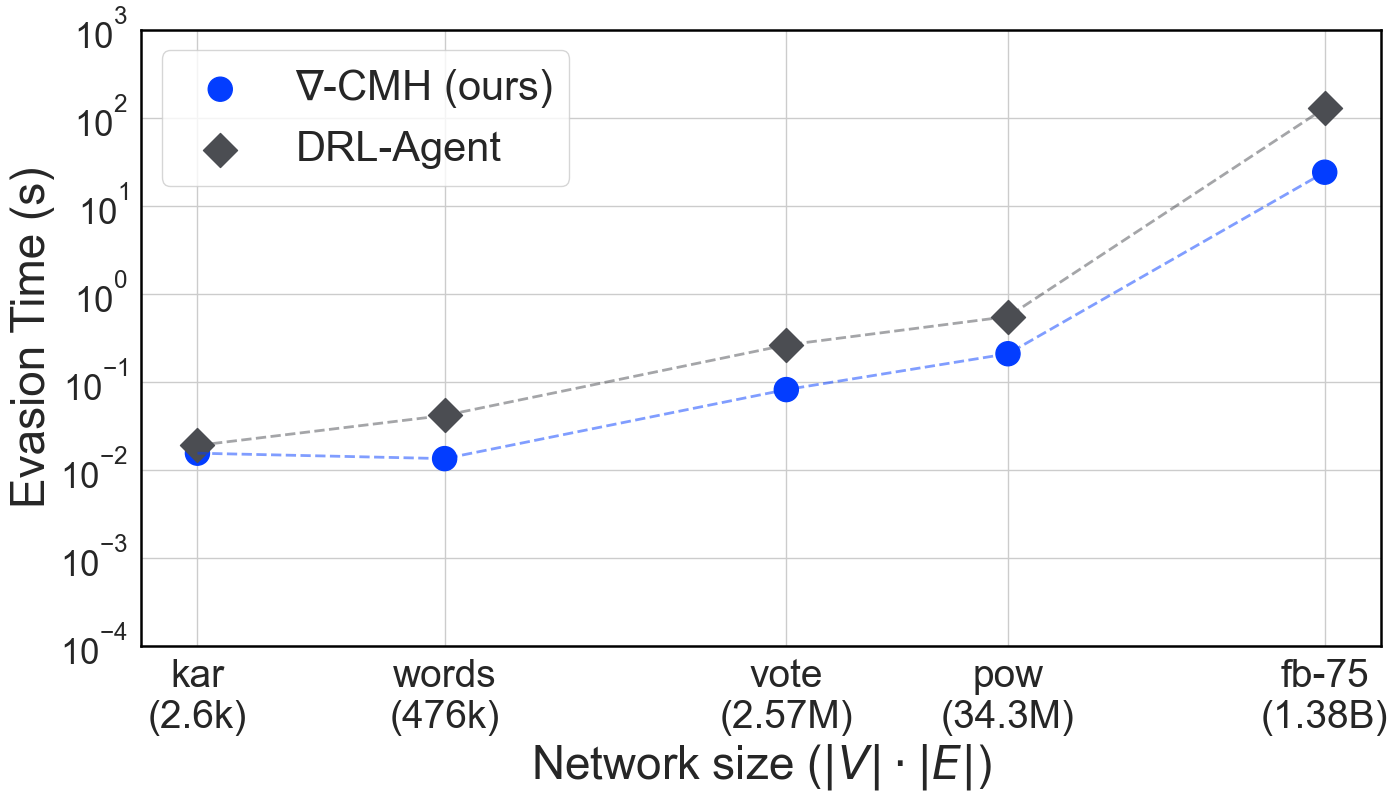

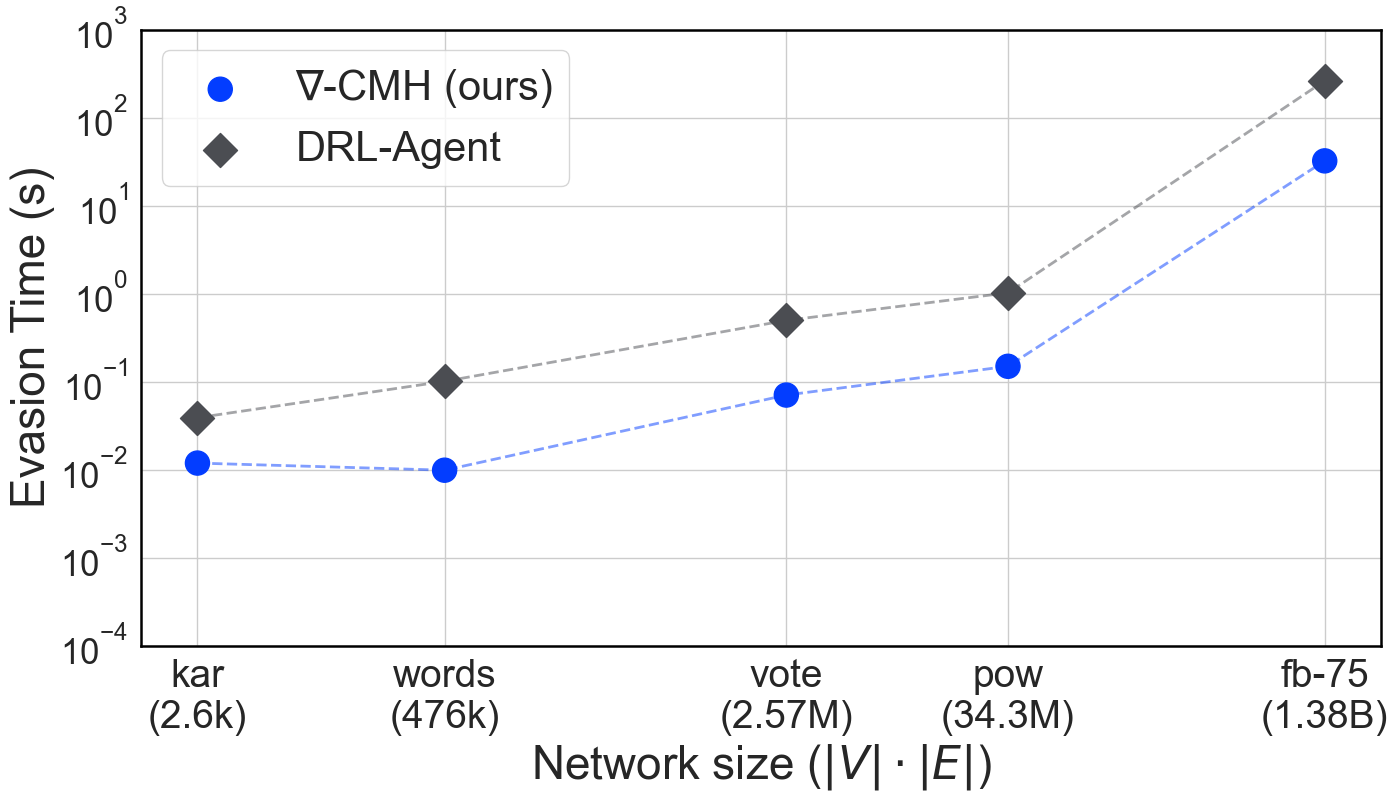

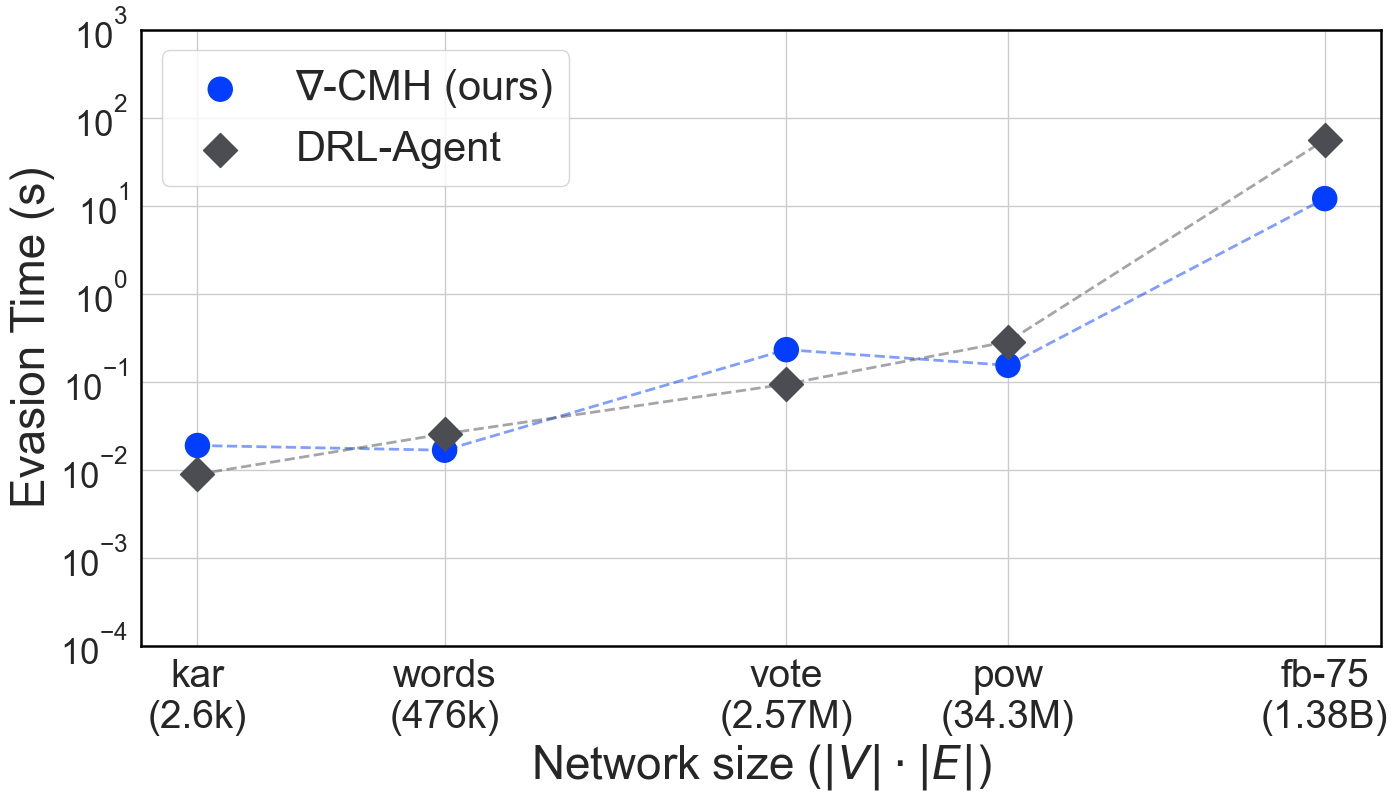

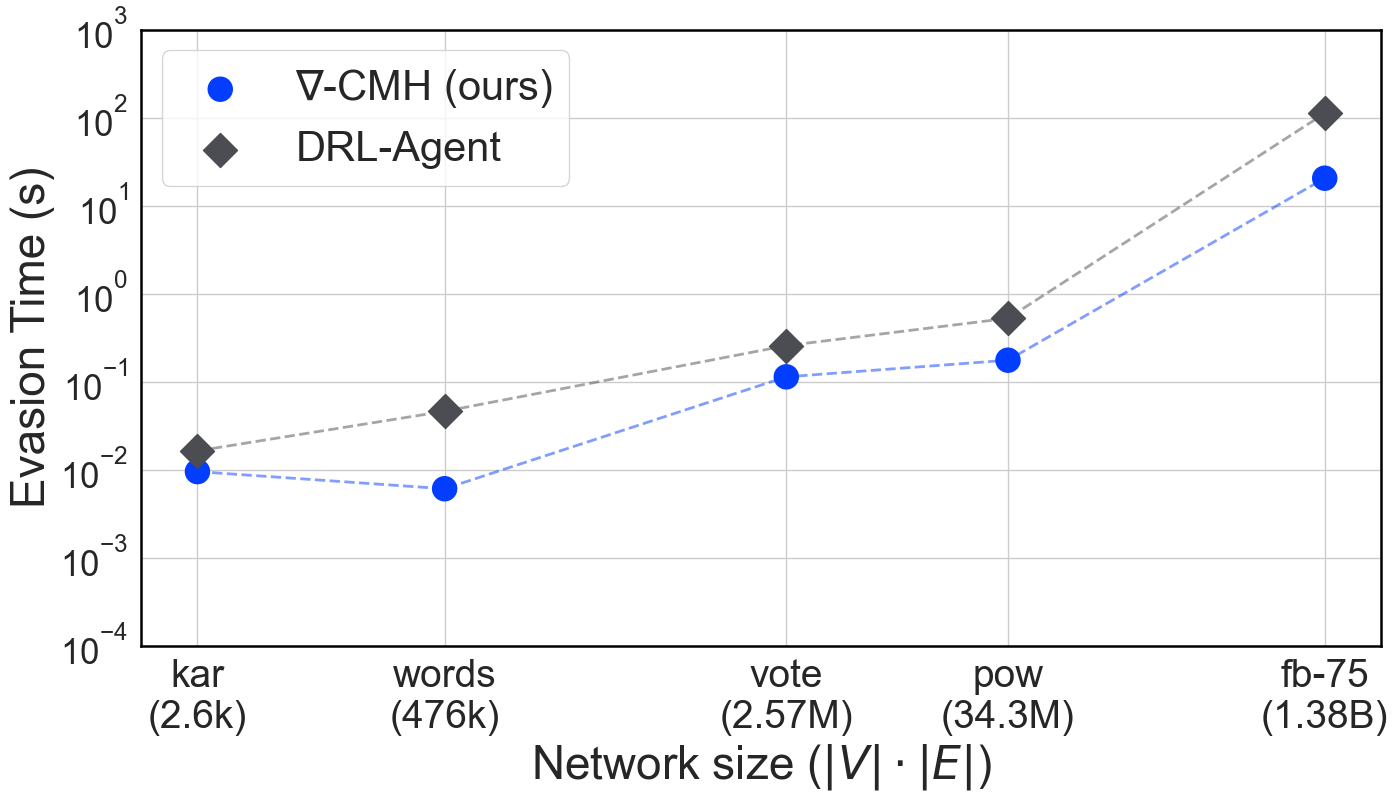

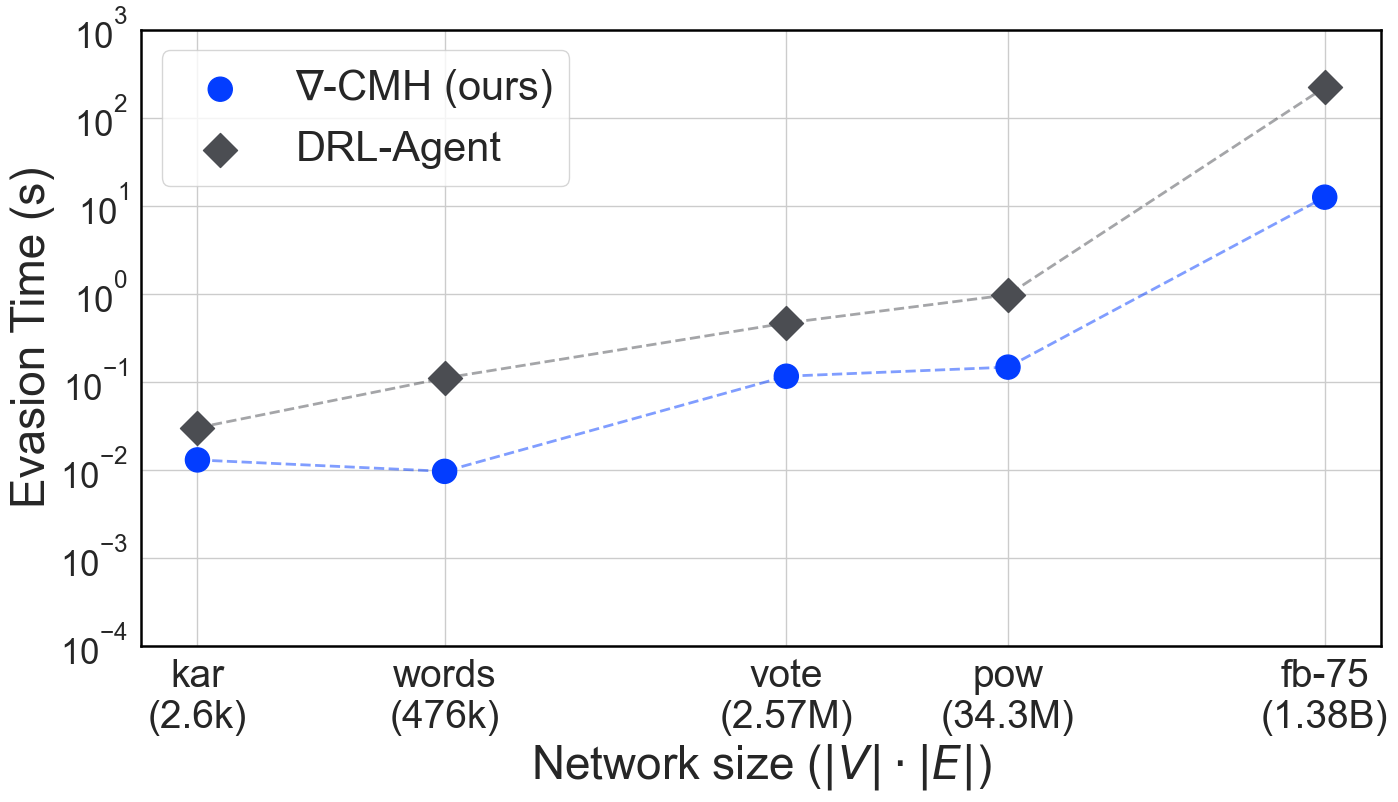

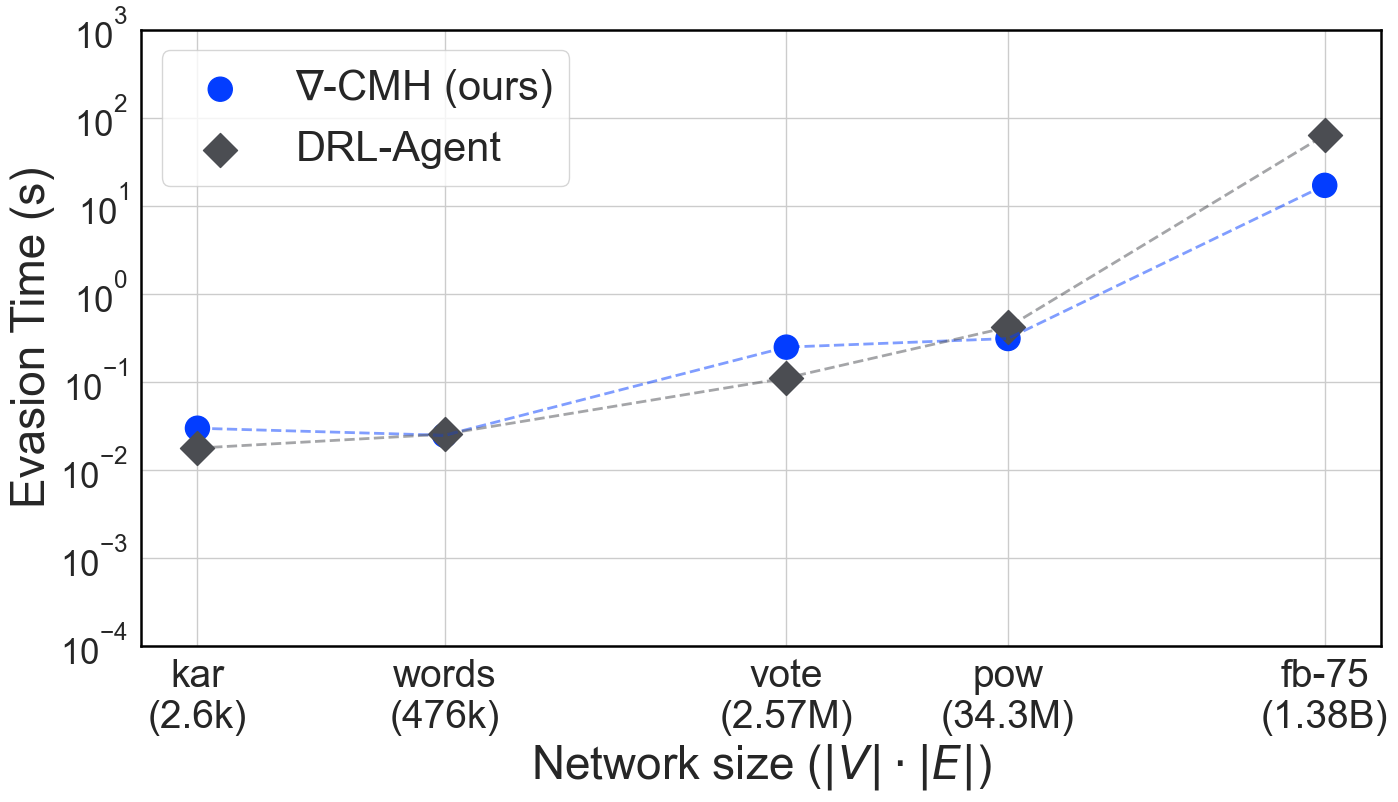

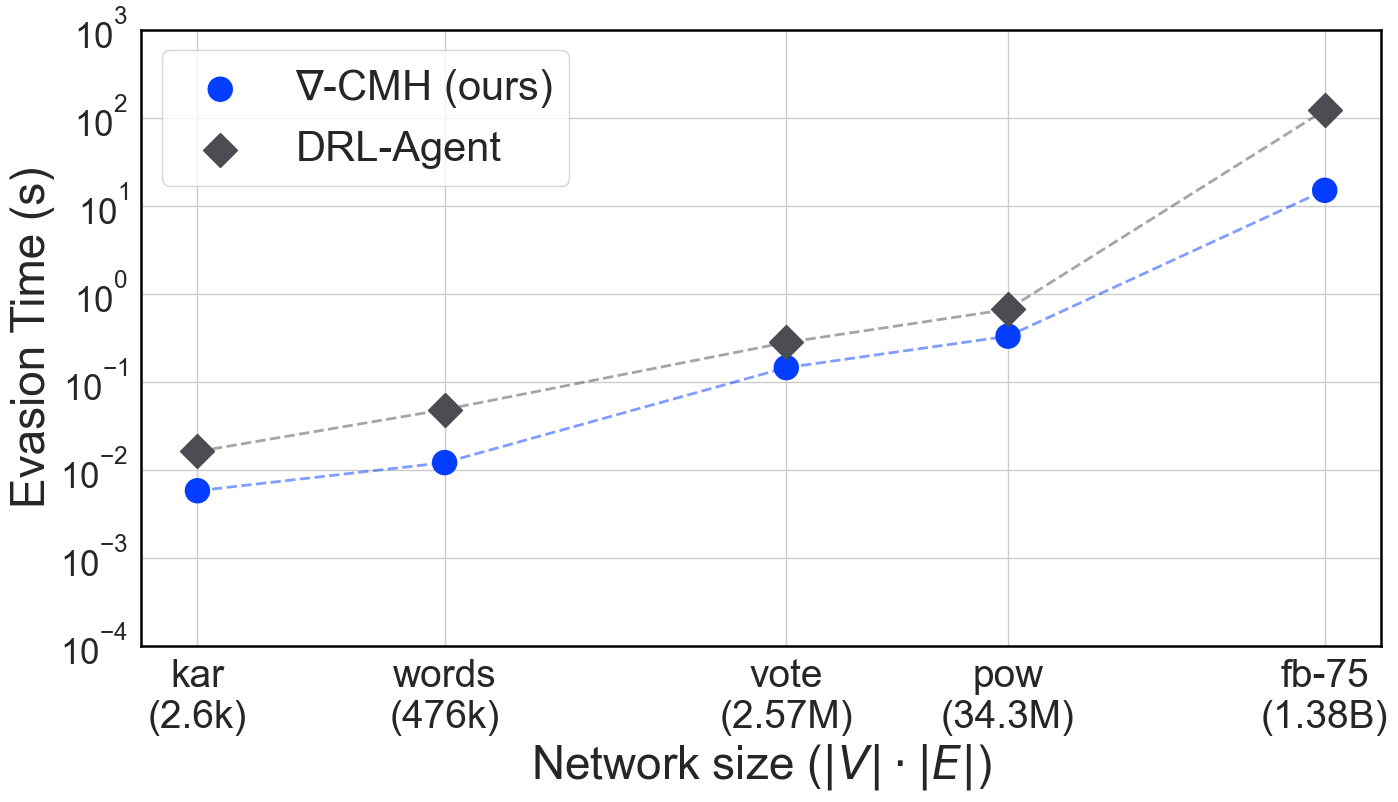

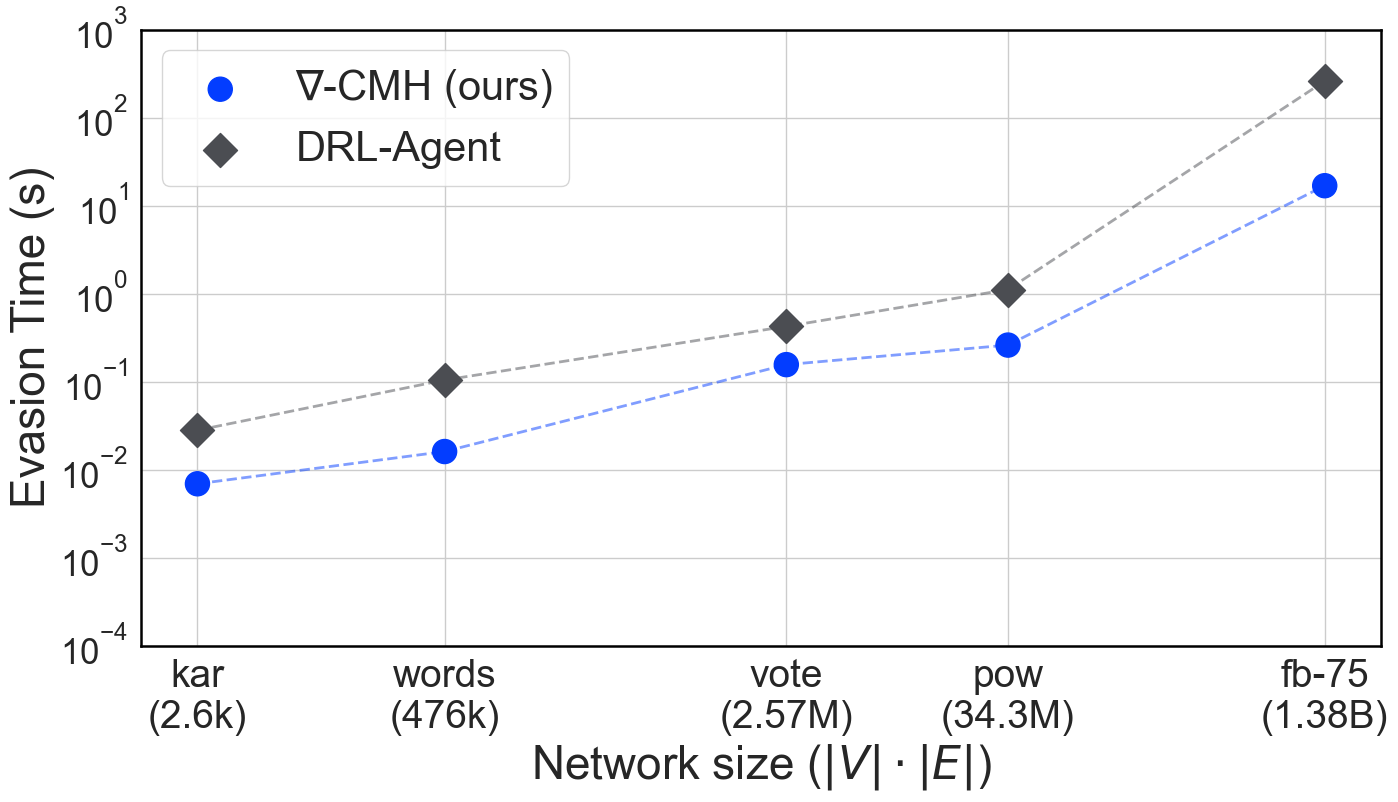

In [56]:
plot_time_all_datasets(
            datasets= [FilePaths.KAR.value,FilePaths.WORDS.value, FilePaths.VOTE.value, FilePaths.POW.value, FilePaths.FB_75.value],
            detection_algs= [ DetectionAlgorithmsNames.GRE.value, DetectionAlgorithmsNames.LOUV.value,DetectionAlgorithmsNames.WALK.value],
            taus=[0.5],
            betas=[0.5,1,2],
        )